<div style="text-align: right">**November 21st**</div>
***
# <center>Expanding Model Features</center>

Notes:

May need to play around w/ clustering.
Include helper function for differentiating clusters.


Last meeting covered cross-validation using n-folds, first with a logistic regression model and then with L1 and L2 (lasso and ridge) regularization models.

For today's meeting, I would like to expand the model with derived features using:

- Observations from the coefficeints of the lasso regularization.
- Intuition from domain knowledge
- K-means clustering of champions

First, I'll import all necessary packages and dataframes.

In [1]:
%store -r teamDF
%store -r norm_teamDF
%store -r playerDF
%store -r featuresDF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

### Coefficients of Lasso Regularization
***

For a quick refresher, these are the predictor coefficients from the lasso regularized regressions performed at our last meeting.

In [10]:
featuresDF.iloc[:,30:].info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, ADC_Urgot to earthdrakes
Data columns (total 9 columns):
7.14             684 non-null float64
7.15             684 non-null float64
7.16             684 non-null float64
7.17             684 non-null float64
mean             684 non-null float64
weighted_mean    684 non-null float64
original         684 non-null float64
mean_diff        684 non-null float64
wm_diff          684 non-null float64
dtypes: float64(9)
memory usage: 53.4+ KB


In [22]:
featuresDF.iloc[:,34:].sort_values(by = 'original').head(10)

,mean,weighted_mean,original,mean_diff,wm_diff
opptowerkills,-0.197738,-0.209109,-0.215261,0.017523,0.006152
gspd,-0.087312,-0.107436,-0.117334,0.030022,0.009898
d,-0.045853,-0.056652,-0.117195,0.071342,0.060543
goldspent,-0.026169,-0.031982,-0.099020,0.072851,0.067038
kpm,-0.006098,-0.007966,-0.080436,0.074338,0.072469
oppbaronkills,-0.022474,-0.024254,-0.027874,0.005400,0.003621
teamdeaths,-0.020594,-0.024799,-0.027299,0.006705,0.002500
firsttothreetowers,-0.007994,-0.011121,-0.018069,0.010075,0.006948
wcpm,-0.000428,0.000753,-0.015912,0.015484,0.015160
fbaron,-0.008202,-0.012775,-0.015005,0.006802,0.002230


In [21]:
featuresDF.iloc[:,34:].sort_values(by = 'original', ascending = False).head(10)

,mean,weighted_mean,original,mean_diff,wm_diff
teamtowerkills,0.183125,0.184580,0.186331,0.003206,0.001750
earnedgpm,0.062884,0.076034,0.125633,0.062749,0.049599
k,0.011223,0.013451,0.080286,0.069063,0.066834
okpm,0.011225,0.015474,0.065290,0.054065,0.049816
minionkills,0.015180,0.017085,0.064718,0.049539,0.047633
a,0.039322,0.043604,0.052831,0.013510,0.009228
wardkills,0.008103,0.011996,0.027593,0.019490,0.015597
dmgtochamps,0.010288,0.014240,0.021388,0.011101,0.007148
teamkills,0.013652,0.017788,0.018108,0.004456,0.000320
teambaronkills,0.013766,0.014066,0.016316,0.002550,0.002250


### Coefficients of Lasso Regularization
***

For easier interpretation, the graph below explains the difference between the original model and the aggregation of the patch-split models.

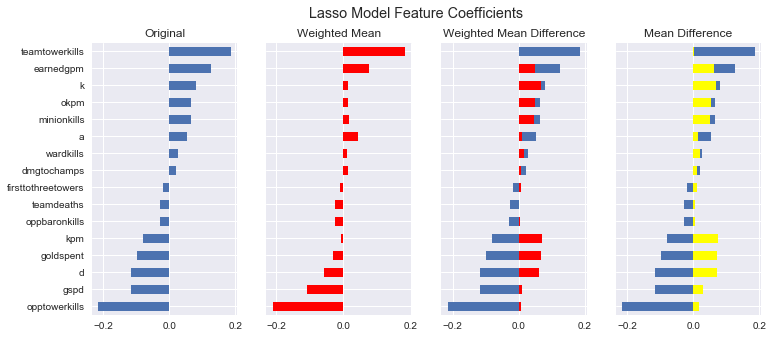

In [73]:
rows = pd.concat([featuresDF['original'].sort_values().head(8), featuresDF['original'].sort_values().tail(8)]).index
plt.figure(figsize=(12, 5))
plt.suptitle('Lasso Model Feature Coefficients')

ax1 = plt.subplot(141)
featuresDF.loc[rows,'original'].plot(kind = "barh")
plt.title("Original")

ax2 = plt.subplot(142, sharey=ax1)
featuresDF.loc[rows, 'weighted_mean'].plot(kind = 'barh', color = 'red')
plt.title("Weighted Mean")

ax3 = plt.subplot(143, sharey=ax1)
featuresDF.loc[rows,'original'].plot(kind = "barh")
featuresDF.loc[rows, 'wm_diff'].plot(kind = 'barh', color = 'red')
plt.title("Weighted Mean Difference")

ax4 = plt.subplot(144, sharey=ax1)
featuresDF.loc[rows,'original'].plot(kind = "barh")
featuresDF.loc[rows, 'mean_diff'].plot(kind = 'barh', color = 'yellow')
plt.title("Mean Difference")

plt.show()

We see that the models are in agreement over the importance of certain features, but strongly differ on others. As a general rule, the values of the patch split model coefficients are lower than the original.

This is because performing this regression on patch specific observations allowed the features that had greater importance in the specific patch (things like picking or banning away the strongest champions of that specific patch) to get more significant coefficient values than  they had received in the original regression. In turn, this decreased the values of features that did not have patch specific significance.

To put it simply, the features where the two regression methods most strongly agreed are the features that are the most important predictors regardless of the game's current meta.

Towers killed and lost are again the strongest predictors of victory and defeat, and the usual suspects come up in terms of kills/deaths, damage dealt, and gold/minons but the models disagree pretty strongly on just how important those other features are. The exception is 'gspd' which refers to gold spent percentage difference - the percent difference in the spending of a team with its opponent. Like towers, gspd is not especially useful as a feature because it is more correlated with victory than causal. The team spending more gold than the other often wins, but they were able to spend more gold because they were winning most of the game.

**Note for future revisions**: gspd may still be worth considering as a way of improving the 'quality' feature I derived earlier by quantile cutting the win percentages of teams. That way rather than just saying a team that wins 50% of its games is average, I can evaluate how closely they win and lose by, since a team smashing in its wins and narrowly losing is obviously much better than a team ekeing out wins and getting obliterated in its losses.

### Coefficients of Lasso Regularization -- Digression
***

This closer look at the previous regression methods has led me to wonder how much more meaningful coefficients values I might be getting without so many features cancelling eachother out. Things like kills ('k') and kills per minute ('kpm') perfectly derivable from the other and gamelength. I think I might get more meaningful information be repeating these regressions on a subset dataframe without so many correlated features. I'll use the results from my VIF (Variance Inflation Factors) testing in an earlier notebook.

Without rerunning that testing, the features that were removed to lower all VIF factors below 10 were:

`['elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills', 'totalgold','gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths', 'wardkills', 'monsterkills', 'goldspent']`

I'll quickly run through all the previous regression steps on this subsetted dataframe.

In [74]:
regressors = list(set(list(norm_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim',
                                               'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills',
                                               'totalgold','gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths',
                                                      'wardkills', 'monsterkills','goldspent', 'league', 'split',
                                                      'week', 'game', 'patchno', 'playerid', 'position', 'player', 'champion']))

X = norm_teamDF.loc[:, regressors]
y = norm_teamDF.loc[:,'result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=10)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [75]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

rmse_cv(model_lasso).mean()

0.16638243541481593

In [76]:
print(model_lasso.score(X_train, y_train))
print(model_lasso.score(X_test, y_test))

0.892013976244
0.883553331715


In [77]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 82 variables and eliminated the other 584 variables


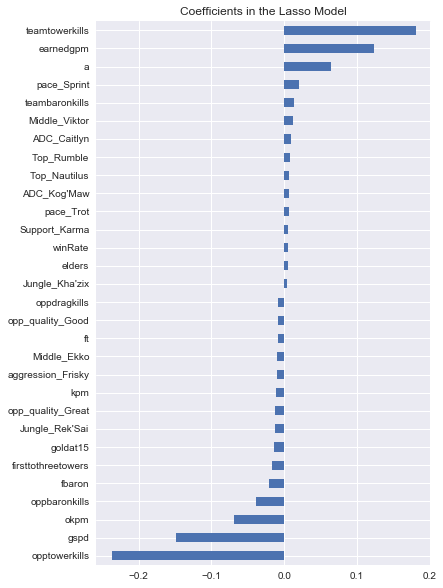

In [78]:
imp_coefs = pd.concat([coef.sort_values().head(15),
                     coef.sort_values().tail(15)])

plt.figure(figsize=(6, 10))
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [81]:
patchDF = norm_teamDF.groupby('patchno')
patchDict = {}
rmseDict = {}

for k, df in patchDF:
    patch_X = df.loc[:, regressors]
    patch_y = df.loc[:,'result']
    
    pX_train, pX_test, py_train, py_test = train_test_split(patch_X, patch_y, test_size = .25, random_state=10)

    ml = LassoCV(alphas = [1, 0.1, 0.001]).fit(pX_train, py_train)
    
    rmseDict[k] = np.sqrt(-cross_val_score(ml, pX_train, py_train, scoring="neg_mean_squared_error", cv = 5)).mean()

    patchDict[k] = pd.Series(ml.coef_, index = pX_train.columns)

In [82]:
_ = []
for k,v in rmseDict.items():
    _.append("Patch " + str(k) + ": " + str(round(v,4)))
print(_)
print('Ranging from ', min(rmseDict.values()), ' to ', max(rmseDict.values()))
print('Average rmse: ', sum(rmseDict.values())/len(rmseDict))

['Patch 5.24: 0.277', 'Patch 6.01: 0.1871', 'Patch 6.02: 0.1646', 'Patch 6.03: 0.2502', 'Patch 6.04: 0.2412', 'Patch 6.05: 0.2267', 'Patch 6.06: 0.1678', 'Patch 6.07: 0.1999', 'Patch 6.08: 0.2419', 'Patch 6.1: 0.2062', 'Patch 6.11: 0.2052', 'Patch 6.12: 0.1994', 'Patch 6.13: 0.193', 'Patch 6.14: 0.172', 'Patch 6.15: 0.1842', 'Patch 6.16: 0.2972', 'Patch 6.18: 0.1366', 'Patch 6.21: 0.2241', 'Patch 7.01: 0.2319', 'Patch 7.02: 0.1626', 'Patch 7.03: 0.2314', 'Patch 7.04: 0.1691', 'Patch 7.05: 0.1757', 'Patch 7.06: 0.1716', 'Patch 7.07: 0.2233', 'Patch 7.08: 0.2364', 'Patch 7.1: 0.196', 'Patch 7.11: 0.1864', 'Patch 7.12: 0.1785', 'Patch 7.13: 0.2054', 'Patch 7.14: 0.1849', 'Patch 7.15: 0.2345', 'Patch 7.16: 0.2045', 'Patch 7.17: 0.278']
Ranging from  0.136639715045  to  0.29721408787
Average rmse:  0.207193125932


In [83]:
for k in patchDict:
    took = str(sum(patchDict[k] != 0))
    left = str(sum(patchDict[k] == 0))
    print("On patch " + str(k) + " -- " + took + " variables taken // " +  left + " dropped")

On patch 5.24 -- 6 variables taken // 660 dropped
On patch 6.01 -- 94 variables taken // 572 dropped
On patch 6.02 -- 91 variables taken // 575 dropped
On patch 6.03 -- 3 variables taken // 663 dropped
On patch 6.04 -- 2 variables taken // 664 dropped
On patch 6.05 -- 7 variables taken // 659 dropped
On patch 6.06 -- 92 variables taken // 574 dropped
On patch 6.07 -- 3 variables taken // 663 dropped
On patch 6.08 -- 6 variables taken // 660 dropped
On patch 6.1 -- 103 variables taken // 563 dropped
On patch 6.11 -- 112 variables taken // 554 dropped
On patch 6.12 -- 108 variables taken // 558 dropped
On patch 6.13 -- 114 variables taken // 552 dropped
On patch 6.14 -- 92 variables taken // 574 dropped
On patch 6.15 -- 96 variables taken // 570 dropped
On patch 6.16 -- 7 variables taken // 659 dropped
On patch 6.18 -- 63 variables taken // 603 dropped
On patch 6.21 -- 2 variables taken // 664 dropped
On patch 7.01 -- 108 variables taken // 558 dropped
On patch 7.02 -- 84 variables taken

In [84]:
new_featuresDF = pd.DataFrame(patchDict)
new_featuresDF['mean'] = new_featuresDF.mean(axis=1)

wts = {}
for k, df in patchDF:
    wts[k] = len(df)/len(teamDF)
    
wts = pd.Series(wts)
new_featuresDF['weighted_mean'] = new_featuresDF.drop('mean', axis = 1).dot(wts)

In [85]:
new_featuresDF['original'] = coef
new_featuresDF['mean_diff'] = abs(new_featuresDF['original']) - abs(new_featuresDF['mean'])
new_featuresDF['wm_diff'] = abs(new_featuresDF['original']) - abs(new_featuresDF['weighted_mean'])

### Lasso Regularization Digression
***
Okay, now that I have a new DF of coefficients, we can see if any features are getting more interpretable coefficient values without the previous counterbalancing measures.

Let's take a quick look at the 'new' original, the mean, and the weighted mean top coefficients.

In [90]:
print("Original: \n", new_featuresDF['original'].sort_values().head(8), "\n")
print(new_featuresDF['original'].sort_values().tail(8)[::-1], '\n')

print("Mean: \n", new_featuresDF['mean'].sort_values().head(8), "\n")
print(new_featuresDF['mean'].sort_values().tail(8)[::-1], '\n')

print("Weighted Mean: \n", new_featuresDF['weighted_mean'].sort_values().head(8), "\n")
print(new_featuresDF['weighted_mean'].sort_values().tail(8)[::-1], '\n')

Original: 
 opptowerkills        -0.237177
gspd                 -0.149173
okpm                 -0.068892
oppbaronkills        -0.038913
fbaron               -0.020532
firsttothreetowers   -0.016449
goldat15             -0.013321
Jungle_Rek'Sai       -0.012448
Name: original, dtype: float64 

teamtowerkills    0.181396
earnedgpm         0.123831
a                 0.064109
pace_Sprint       0.019958
teambaronkills    0.013914
Middle_Viktor     0.012637
ADC_Caitlyn       0.009893
Top_Rumble        0.008730
Name: original, dtype: float64 

Mean: 
 opptowerkills        -0.213317
gspd                 -0.096684
okpm                 -0.044758
oppbaronkills        -0.026395
fbaron               -0.010243
firsttothreetowers   -0.008059
visionwardbuys       -0.007545
ADC_Sivir            -0.007213
Name: mean, dtype: float64 

teamtowerkills    0.181750
earnedgpm         0.063685
a                 0.042864
teambaronkills    0.011764
Top_Rumble        0.010497
ban3_Zyra         0.009942
Middle_Oria

### Lasso Regularization Digression
***

Again, this will be easier to interpret visually, with the original graphs in the bottom row for referrence.

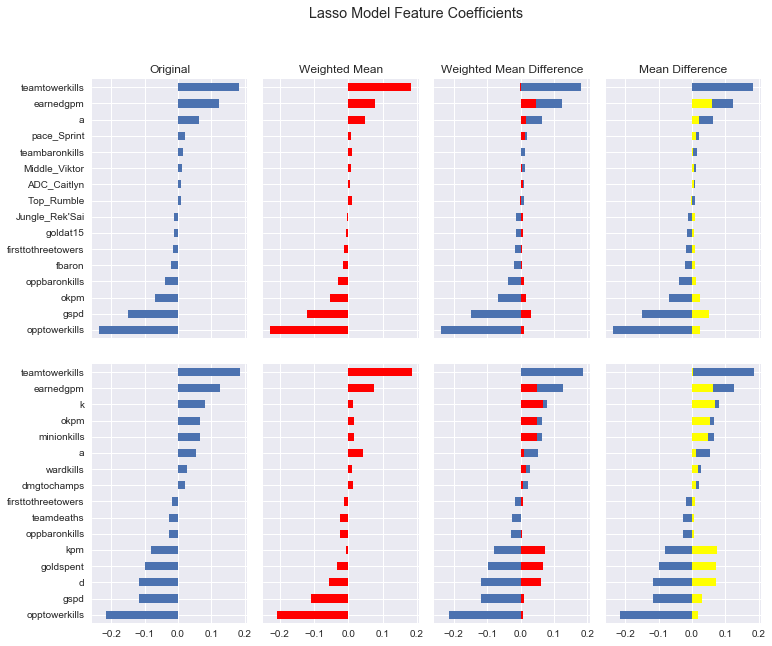

In [98]:
rows = pd.concat([new_featuresDF['original'].sort_values().head(8), new_featuresDF['original'].sort_values().tail(8)]).index
plt.figure(figsize=(12, 10))
plt.suptitle('Lasso Model Feature Coefficients')

ax1 = plt.subplot(241)
new_featuresDF.loc[rows,'original'].plot(kind = "barh")
plt.title("Original")

ax2 = plt.subplot(242, sharey=ax1)
new_featuresDF.loc[rows, 'weighted_mean'].plot(kind = 'barh', color = 'red')
plt.title("Weighted Mean")

ax3 = plt.subplot(243, sharey=ax1)
new_featuresDF.loc[rows,'original'].plot(kind = "barh")
new_featuresDF.loc[rows, 'wm_diff'].plot(kind = 'barh', color = 'red')
plt.title("Weighted Mean Difference")

ax4 = plt.subplot(244, sharey=ax1)
new_featuresDF.loc[rows,'original'].plot(kind = "barh")
new_featuresDF.loc[rows, 'mean_diff'].plot(kind = 'barh', color = 'yellow')
plt.title("Mean Difference")


r = pd.concat([featuresDF['original'].sort_values().head(8), featuresDF['original'].sort_values().tail(8)]).index

ax5 = plt.subplot(245, sharex = ax1)
featuresDF.loc[r,'original'].plot(kind = "barh")

ax6 = plt.subplot(246, sharey=ax5, sharex = ax2)
featuresDF.loc[r, 'weighted_mean'].plot(kind = 'barh', color = 'red')

ax7 = plt.subplot(247, sharey=ax5, sharex = ax3)
featuresDF.loc[r,'original'].plot(kind = "barh")
featuresDF.loc[r, 'wm_diff'].plot(kind = 'barh', color = 'red')

ax8 = plt.subplot(248, sharey=ax5, sharex = ax4)
featuresDF.loc[r,'original'].plot(kind = "barh")
featuresDF.loc[r, 'mean_diff'].plot(kind = 'barh', color = 'yellow')

plt.subplots_adjust(hspace=0.1, wspace=0.1)

plt.show()

Definitely get a new look at the feature selection. These coefficients are much more sensible (like okpm being negative instead of positive) because the regression is no longer doing strange balancing measures to account for redundant information.

In [123]:
%store new_featuresDF

Stored 'new_featuresDF' (DataFrame)


### Work in Progress
***

                        result  dmgshare  dmgtochampsperminute
result                1.000000  0.055863              0.275029
dmgshare              0.055863  1.000000              0.755741
dmgtochampsperminute  0.275029  0.755741              1.000000


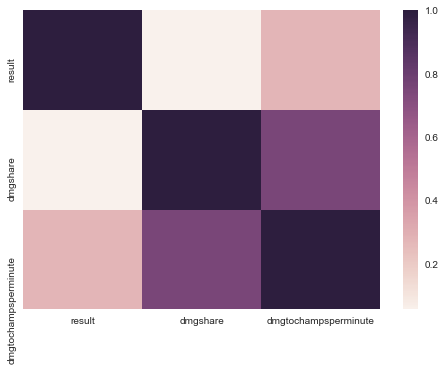

In [114]:
dshare_corr = playerDF.loc[playerDF.position == 'ADC', ['result', 'dmgshare', 'dmgtochampsperminute']].corr()
print(dshare_corr)
sns.heatmap(dshare_corr, 
            xticklabels=dshare_corr.columns.values,
            yticklabels=dshare_corr.columns.values)
plt.show()

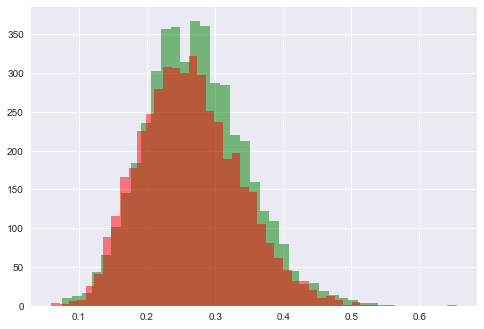

In [115]:
# playerDF.loc[playerDF.position == 'ADC','dmgshare'].hist(bins = 40)
playerDF.loc[(playerDF.position == 'ADC') & (playerDF.result == 1),'dmgshare'].hist(color='green', alpha = .5, bins = 40)
playerDF.loc[(playerDF.position == 'ADC') & (playerDF.result == 0),'dmgshare'].hist(color='red', alpha = .5, bins = 40)

plt.show()

In [116]:
print(playerDF.loc[(playerDF.position == 'ADC'),'dmgshare'].quantile(.9))

0.36261828979961735


In [117]:
hyperDF = playerDF.loc[(playerDF.position == 'ADC'),['gameid', 'team', 'dmgshare']].copy()
hyperDF['hyper'] = False
hyperDF.loc[(hyperDF.dmgshare >= .36),'hyper'] = True
print(hyperDF.sample(10))
hyperDF.drop('dmgshare', axis = 'columns', inplace = True)

                              gameid                 team  dmgshare  hyper
13748                     1001670139               Origen  0.304271  False
1767                      1001480009               Giants  0.302492  False
17847                     1001690146               Roccat  0.274664  False
13664                     1001670118               Splyce  0.243194  False
41871                     1002130330          Team Liquid  0.248797  False
32525  2017-123Vici GamingQG Reapers           QG Reapers       NaN  False
38832      2017-162LGD GamingTeam WE           LGD Gaming       NaN  False
32576                          40515  Jin Air Green Wings  0.310699  False
58968               2017-271I MayOMG                I May       NaN  False
11919                     1001660126               Giants  0.212382  False


In [118]:
hyperDF.set_index(['gameid', 'team'], inplace = True)
hyperDF.sort_index(inplace = True)
dmg_teamDF = dmg_teamDF.join(hyperDF)

print(dmg_teamDF.head(10))

                             result  some_dmg  mid_dmg  high_dmg  hyper
gameid  team                                                           
1000029 Jin Air Green Wings       1       2.0      1.0       1.0   True
        SBENU Sonicboom           0       4.0      0.0       0.0  False
1000116 CJ Entus                  1       2.0      1.0       0.0  False
        SBENU Sonicboom           0       2.0      1.0       1.0  False
1000306 Kongdoo Monster           0       2.0      2.0       0.0  False
        Longzhu Gaming            1       3.0      1.0       0.0   True
1000316 Kongdoo Monster           0       2.0      2.0       0.0  False
        Longzhu Gaming            1       2.0      1.0       0.0  False
1000320 Jin Air Green Wings       1       3.0      0.0       0.0  False
        KT Rolster                0       2.0      1.0       0.0  False


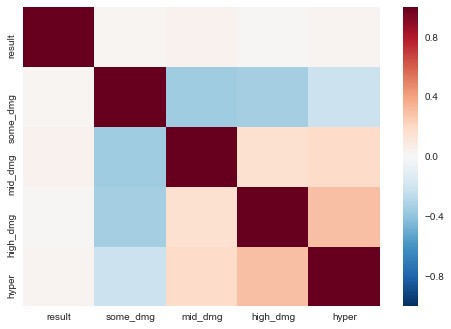

In [119]:
d_corr = dmg_teamDF.corr()
sns.heatmap(d_corr, 
            xticklabels=d_corr.columns.values,
            yticklabels=d_corr.columns.values)
plt.show()

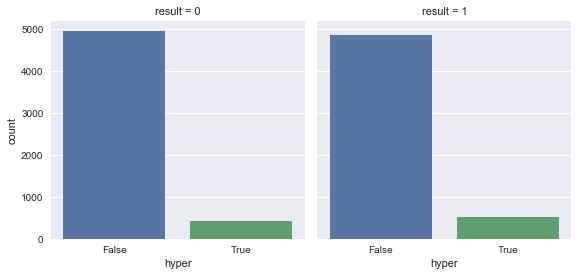

In [122]:
ay = sns.factorplot( x="hyper", col = 'result', data=dmg_teamDF, kind = 'count', margin_titles = True);

plt.show()

In [140]:
print(dmg_teamDF.loc[(dmg_teamDF.hyper == True), 'result'].mean())

carry = dmg_teamDF[dmg_teamDF['hyper'] == True]['result']
no_carry = dmg_teamDF[dmg_teamDF['hyper'] == False]['result']
stats.ttest_ind(carry, no_carry)

0.546694648478489


Ttest_indResult(statistic=3.0204944177514403, pvalue=0.0025295356669416767)

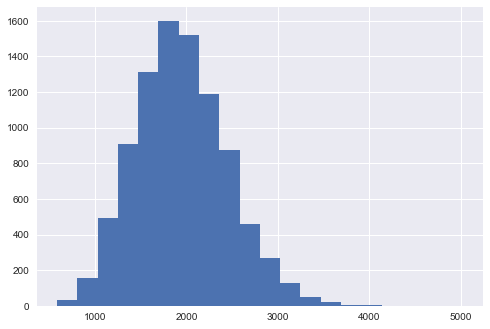

In [147]:
teamDF.dmgtochampsperminute.hist(bins = 20)
plt.show()
#  'quality',
#  'pace',
#  'aggression',
#  'opp_quality']

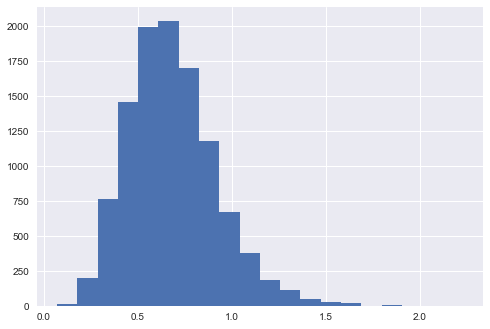

In [149]:
teamDF.ckpm.hist(bins = 20)
plt.show()

In [99]:
dmgDF = playerDF[['gameid', 'team', 'position', 'dmgshare']].copy()

dmgDF.loc[dmgDF.dmgshare < 0.20, 'some_dmg'] = 0
dmgDF.loc[dmgDF.dmgshare >= 0.20, 'some_dmg'] = 1

dmgDF.loc[dmgDF.dmgshare < 0.3, 'mid_dmg'] = 0
dmgDF.loc[dmgDF.dmgshare >= 0.3, 'mid_dmg'] = 1

dmgDF.loc[dmgDF.dmgshare < 0.4, 'high_dmg'] = 0
dmgDF.loc[dmgDF.dmgshare >= 0.4, 'high_dmg'] = 1

dmgDF.drop(['position', 'dmgshare'], axis = 1, inplace = True)
dmgDF.set_index(['gameid', 'team'], inplace = True)
dmgDF.sort_index(inplace=True)

dmgDF = dmgDF.groupby(dmgDF.index).sum()

dmgDF.index = pd.MultiIndex.from_tuples(dmgDF.index, names=['gameid', 'team'])
dmgDF.head(20)

dmg_teamDF = teamDF[['gameid', 'team', 'result']].copy()
dmg_teamDF.set_index(['gameid', 'team'], inplace = True)
dmg_teamDF.sort_index(inplace=True)
dmg_teamDF = dmg_teamDF.join(dmgDF)

dmg_teamDF.head(10)


result  some_dmg  mid_dmg  high_dmg
gameid  team                                                    
1000029 Jin Air Green Wings       1       2.0      1.0       1.0
        SBENU Sonicboom           0       4.0      0.0       0.0
1000116 CJ Entus                  1       2.0      1.0       0.0
        SBENU Sonicboom           0       2.0      1.0       1.0
1000306 Kongdoo Monster           0       2.0      2.0       0.0
        Longzhu Gaming            1       3.0      1.0       0.0
1000316 Kongdoo Monster           0       2.0      2.0       0.0
        Longzhu Gaming            1       2.0      1.0       0.0
1000320 Jin Air Green Wings       1       3.0      0.0       0.0
        KT Rolster                0       2.0      1.0       0.0

In [100]:
d_corr = dmg_teamDF.corr()
d_corr.result

result      1.000000
some_dmg    0.019330
mid_dmg     0.041745
high_dmg    0.014653
Name: result, dtype: float64

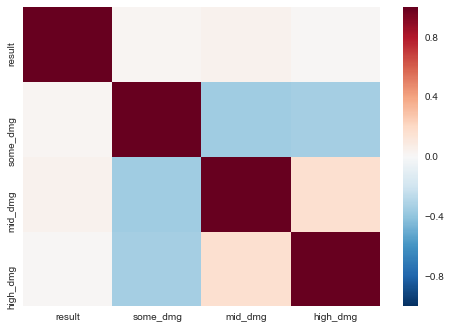

In [101]:
sns.heatmap(d_corr, 
            xticklabels=d_corr.columns.values,
            yticklabels=d_corr.columns.values)
plt.show()

In [103]:
dmg_teamDF.describe()

,result,some_dmg,mid_dmg,high_dmg
count,10782.000000,9020.000000,9020.000000,9020.000000
mean,0.500000,2.441131,0.808093,0.113969
std,0.500023,0.636661,0.571024,0.317791
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000
50%,0.500000,2.000000,1.000000,0.000000
75%,1.000000,3.000000,1.000000,0.000000
max,1.000000,5.000000,2.000000,1.000000


In [104]:
dmg_teamDF.loc[dmg_teamDF.high_dmg > 0, 'result'].mean()

0.5204280155642024

In [106]:
carry = dmg_teamDF[dmg_teamDF['high_dmg'] > 0]['result']
no_carry = dmg_teamDF[dmg_teamDF['high_dmg'] == 0]['result']
stats.ttest_ind(carry, no_carry)

Ttest_indResult(statistic=1.3916394750601777, pvalue=0.16406592280702423)

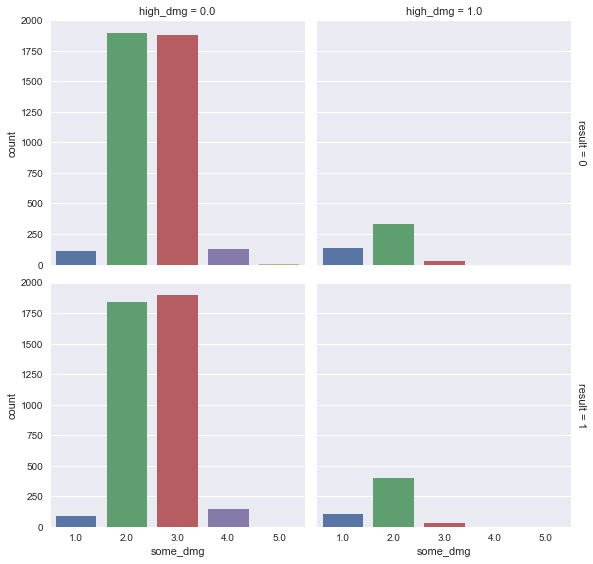

In [107]:
ay = sns.factorplot( x="some_dmg", col = 'high_dmg', row = 'result', data=dmg_teamDF, kind = 'count', margin_titles = True);

plt.show()

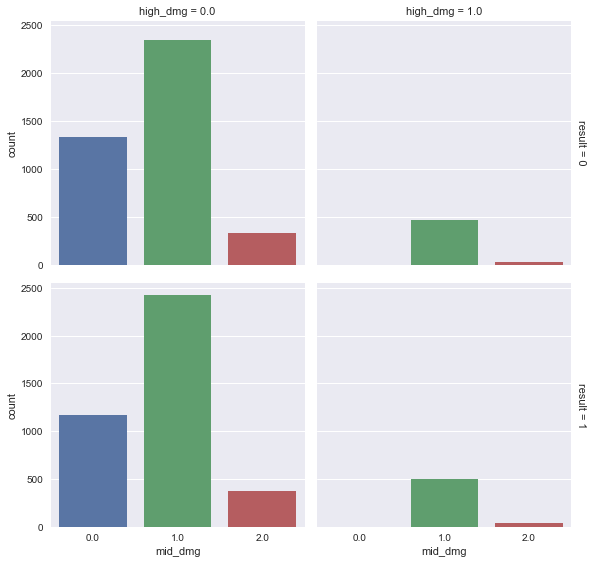

In [108]:
ay = sns.factorplot( x="mid_dmg", col = 'high_dmg', row = 'result', data=dmg_teamDF, kind = 'count', margin_titles = True);

plt.show()

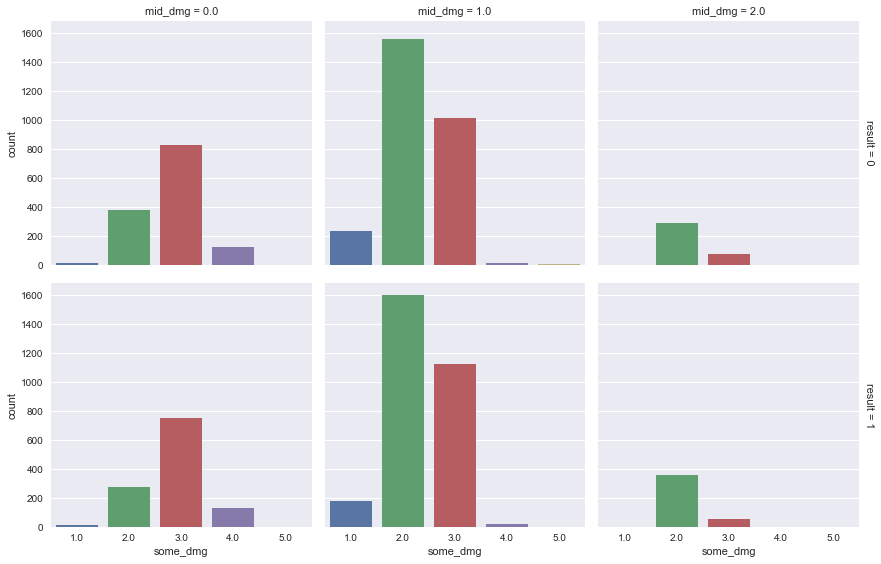

In [109]:
ay = sns.factorplot( x="some_dmg", col = 'mid_dmg', row = 'result', data=dmg_teamDF, kind = 'count', margin_titles = True);

plt.show()

In [111]:
# plt.figure(figsize=(20,10))
# plt.subplot(2,2,1)
# ax = sns.countplot(x="quality", hue="pace", data=teamDF[teamDF['result'] == 1])

# plt.subplot(2,2,2)
# ay = sns.countplot(hue="aggression", x="pace", data=teamDF[teamDF['result'] == 1])

# plt.subplot(2,2,3)
# ay = sns.countplot(hue="aggression", x="quality", data=teamDF[teamDF['result'] == 1])

# plt.show()

In [81]:
# ay = sns.factorplot( x="dmgshare", col = 'position', row = 'result', data=playerDF, kind = 'count', margin_titles = True);

# plt.show()